In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd 
import seaborn as sns
import time
from scipy.io import arff
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier

In [2]:
# Timing a large file load with Pandas
start_time = time.perf_counter()
df = pd.read_csv("undersampled_CIC2019_dataset.csv")
end_time = time.perf_counter()
elapsed_time_pandas = end_time - start_time
print(f"Pandas load time: {elapsed_time_pandas:.4f} seconds")

Pandas load time: 21.1825 seconds


In [3]:
# Drop non-numeric or identifier columns
X = df.drop(columns=["label"], errors="ignore")
X = X.select_dtypes(include=[np.number])

le = LabelEncoder()
df["label"] = le.fit_transform(df["label"])

X = df.drop(columns=["label"], errors="ignore").select_dtypes(include=[np.number])
y = df["label"]

# Handle missing values
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(0, inplace=True)

print("Classes:", dict(zip(le.classes_, range(len(le.classes_)))))

Classes: {'BENIGN': 0, 'DrDoS_DNS': 1, 'DrDoS_LDAP': 2, 'DrDoS_MSSQL': 3, 'DrDoS_NTP': 4, 'DrDoS_NetBIOS': 5, 'DrDoS_SNMP': 6, 'DrDoS_SSDP': 7, 'DrDoS_UDP': 8, 'LDAP': 9, 'MSSQL': 10, 'NetBIOS': 11, 'Portmap': 12, 'Syn': 13, 'TFTP': 14, 'UDP': 15, 'UDP-lag': 16, 'UDPLag': 17, 'WebDDoS': 18}


In [4]:
# Handle missing & infinite values
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(0, inplace=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
#removing noisy features
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)
X_train = selector.fit_transform(X_train)
X_test = selector.transform(X_test)

In [9]:
model = XGBClassifier(
    n_estimators=1000,  
    max_depth=6,       
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1          # -1 means use all available cores
)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=-1, num_parallel_tree=None, objective='multi:softprob', ...)

In [10]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob, multi_class="ovr"))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.790380771787695
ROC-AUC: 0.9840672603099435

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10655
           1       0.72      0.86      0.78    178752
           2       0.68      0.15      0.25     58000
           3       0.67      0.64      0.66     30000
           4       1.00      1.00      1.00    183522
           5       0.77      0.77      0.77     13000
           6       0.55      0.56      0.55     83000
           7       0.65      0.40      0.49     21330
           8       0.51      0.39      0.44     21000
           9       0.50      0.56      0.53     58000
          10       0.73      0.74      0.73     38000
          11       0.73      0.81      0.77     11011
          12       0.76      0.48      0.59      1122
          13       1.00      1.00      1.00      8401
          14       1.00      1.00      1.00    190059
          15       0.51      0.73      0.60     30000


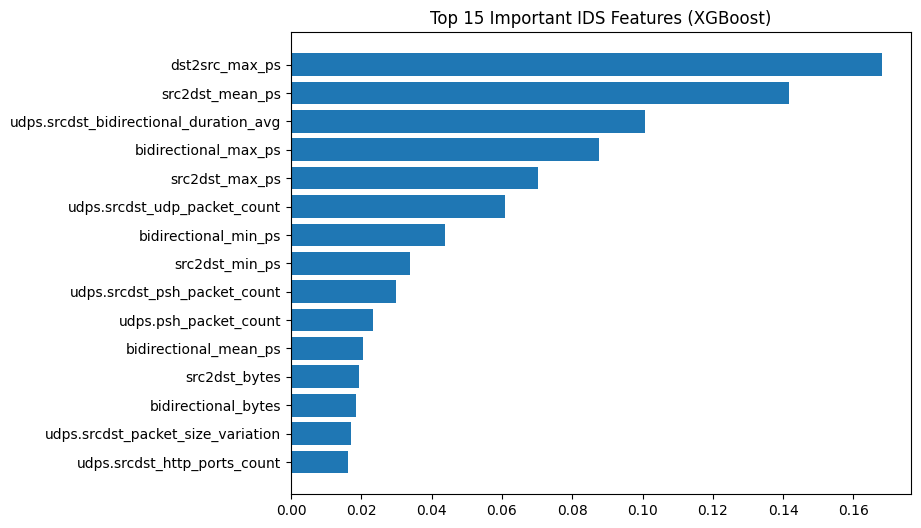

In [11]:
importances = model.feature_importances_
indices = np.argsort(importances)[-15:]

plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), X.columns[indices])
plt.title("Top 15 Important IDS Features (XGBoost)")
plt.show()